In [1]:
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.neighbors import NearestNeighbors

## Data Ingestion

In [2]:
filename: str = "../input.csv"
data = []
with open(filename, "r") as input_file:
    csv_reader = csv.reader(input_file, delimiter=',')
    for line in csv_reader:
        data.append(tuple(int(x) for x in line))


## Configuration

In [3]:
# number of representative points to pick from the input data
NUM_REPS = 10

## Clustering

In [17]:
def mean_of_points(points: list) -> tuple[float, float]:
    """https://stackoverflow.com/a/4355934"""
    return (
        sum([p[0] for p in points]) / len(points), 
        sum([p[1] for p in points]) / len(points)
    )

### k-Means

In [4]:
kmeans = KMeans(
    n_clusters=NUM_REPS,
    init='random', 
    n_init=80,
    max_iter=300
)
kmeans.fit(data)
kmeans_centroids = kmeans.cluster_centers_

### Hierarchical

In [18]:
hcluster = AgglomerativeClustering(
    n_clusters=NUM_REPS,
    linkage='complete'
)
hcluster.fit(data)
hcluster_labels = hcluster.labels_

hcluster_groups = [[] for i in range(NUM_REPS)]
for point, label in zip(data, hcluster_labels):
    hcluster_groups[label].append(point)

hcluster_centroids = []
for group in hcluster_groups:
    hcluster_centroids.append(mean_of_points(group))

### Birch

In [20]:
brch = Birch(
    n_clusters=NUM_REPS, 
    copy=True
)
brch_labels = brch.fit_predict(data)

birch_groups = [[] for i in range(NUM_REPS)]
for point, label in zip(data, brch_labels):
    birch_groups[label].append(point)

birch_centroids = []
for group in birch_groups:
    birch_centroids.append(mean_of_points(group))

## 1-NN to Centroids from Input Data

### k-Means

In [21]:
knn = NearestNeighbors(n_neighbors=1).fit(data)
kmeans_neighbors_idx = knn.kneighbors(kmeans_centroids, n_neighbors=1, return_distance=False)
kmeans_closest_points_set = set(data[x[0]] for x in kmeans_neighbors_idx)
kmeans_closest_points = list(kmeans_closest_points_set)
print(kmeans_closest_points)

[(3827, 6064), (6245, 7039), (2130, 6694), (7048, 4554), (5267, 3372), (2862, 5270), (7347, 6193), (4349, 3861), (6580, 5556), (2925, 3861)]


### Hierarchical

In [22]:
knn = NearestNeighbors(n_neighbors=1).fit(data)
hcluster_neighbors_idx = knn.kneighbors(hcluster_centroids, n_neighbors=1, return_distance=False)
hcluster_closest_points_set = set(data[x[0]] for x in hcluster_neighbors_idx)
hcluster_closest_points = list(hcluster_closest_points_set)
print(hcluster_closest_points)

[(6250, 6915), (1199, 8724), (7214, 4256), (5494, 1672), (3920, 8304), (6880, 5627), (3188, 5989), (4769, 3632), (2925, 3861), (9344, 8190)]


### Birch

In [23]:
knn = NearestNeighbors(n_neighbors=1).fit(data)
birch_neighbors_idx = knn.kneighbors(birch_centroids, n_neighbors=1, return_distance=False)
birch_closest_points_set = set(data[x[0]] for x in birch_neighbors_idx)
birch_closest_points = list(birch_closest_points_set)
print(birch_closest_points)

[(7409, 6504), (6460, 5845), (5376, 3389), (3827, 6064), (6200, 7072), (1199, 8724), (4349, 3861), (7031, 4666), (2797, 5812), (2925, 3861)]


## Plotting

### k-Means

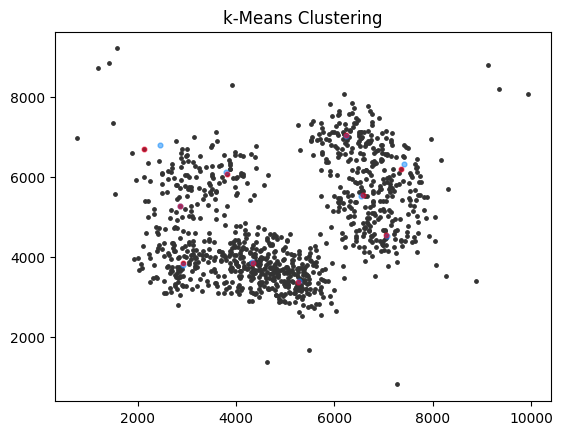

In [32]:
plt.scatter(
    [x[0] for x in data], 
    [y[1] for y in data], 
    s=6,
    color='#333333'
)

plt.scatter(
    [x[0] for x in kmeans_centroids], 
    [y[1] for y in kmeans_centroids], 
    s=12,
    color='#0784f97f'
)

plt.scatter(
    [x[0] for x in kmeans_closest_points], 
    [y[1] for y in kmeans_closest_points], 
    s=12,
    color='#fc052e7f'
)
plt.title("k-Means Clustering")
plt.show()

### Hierarchical

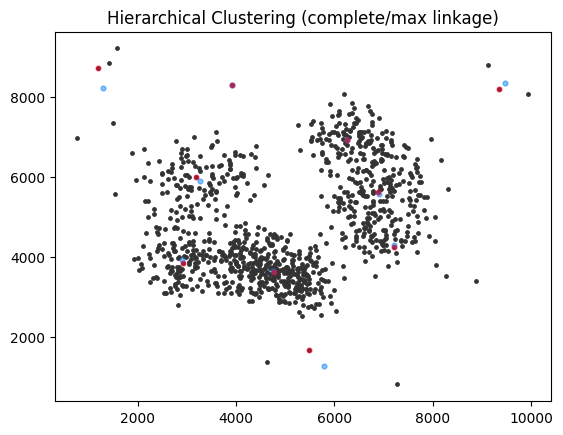

In [33]:
plt.scatter(
    [x[0] for x in data], 
    [y[1] for y in data], 
    s=6,
    color='#333333'
)

plt.scatter(
    [x[0] for x in hcluster_centroids], 
    [y[1] for y in hcluster_centroids], 
    s=12,
    color='#0784f97f'
)

plt.scatter(
    [x[0] for x in hcluster_closest_points_set], 
    [y[1] for y in hcluster_closest_points_set], 
    s=12,
    color='#fc052e7f'
)
plt.title("Hierarchical Clustering (complete/max linkage)")
plt.show()

### Birch

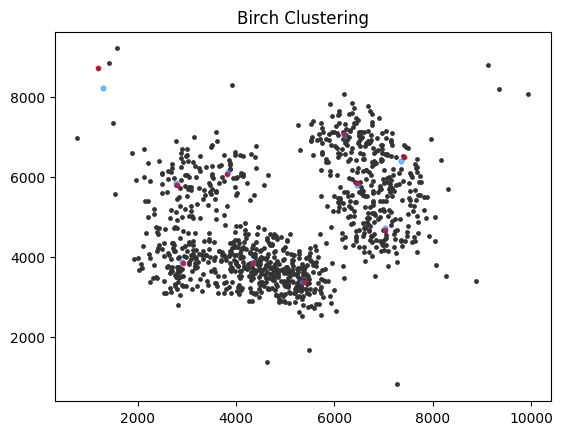

In [34]:
plt.scatter(
    [x[0] for x in data], 
    [y[1] for y in data], 
    s=6,
    color='#333333'
)

plt.scatter(
    [x[0] for x in birch_centroids], 
    [y[1] for y in birch_centroids], 
    s=12,
    color='#0784f97f'
)

plt.scatter(
    [x[0] for x in birch_closest_points_set], 
    [y[1] for y in birch_closest_points_set], 
    s=12,
    color='#fc052e7f'
)
plt.title("Birch Clustering")
plt.show()

## Analysis

In [35]:
def point_distance(a: tuple[int, int], b: tuple[int, int]) -> float:
    """Return the Euclidean distance between two 2D input points."""
    return ((b[0] - a[0])**2 + (b[1] - a[1])**2)**(1/2)

### Naive Total Distance

In [36]:
def data_to_rep_total_dist(input_data: list, reps: list) -> float:
    """
    Return the sum of all distances from a point to all reps
    """
    distance_sum = 0
    for i in input_data:
        for j in reps:
            distance_sum += point_distance(i, j)
    return distance_sum

print("k-Means:\t", data_to_rep_total_dist(data, kmeans_closest_points))
print("Hierarchical:\t", data_to_rep_total_dist(data, hcluster_closest_points))
print("Birch:\t", data_to_rep_total_dist(data, birch_closest_points))

k-Means:	 27199368.66789391
Hierarchical:	 34850046.227769665
Birch:	 29516425.26664232


### Distances to Closest Rep Points
Take all points not selected as a rep, find their closest rep,  compute their distance.

In [37]:
def dists_to_closest_rep(input_data: list, reps) -> tuple[float, float, float]:
    """
    Return min, max, average.
    """
    dists_to_closest_rep = []
    for point in input_data:
        if point not in reps:
            closest_rep = min(reps, key=lambda rep: point_distance(point, rep))
            dists_to_closest_rep.append(point_distance(point, closest_rep))
    return min(dists_to_closest_rep), max(dists_to_closest_rep), (sum(dists_to_closest_rep)/len(dists_to_closest_rep))

stats_kmeans = dists_to_closest_rep(data, kmeans_closest_points_set)
stats_hcluster = dists_to_closest_rep(data, hcluster_closest_points_set)
stats_birch = dists_to_closest_rep(data, birch_closest_points_set)

print(f"Stats k-Means: {stats_kmeans}")
print(f"Stats H-Clustering: {stats_hcluster}")
print(f"Stats Birch: {stats_birch}")

Stats k-Means: (7.211102550927978, 3246.6056120200374, 525.9409462040471)
Stats H-Clustering: (43.840620433565945, 1976.1905272518638, 639.4778736956712)
Stats Birch: (7.0710678118654755, 3193.8431395420785, 533.9813455856188)


### Closest Distance Between Reps

In [38]:
def min_dist_between_reps(reps) -> float:
    """
    """
    dist = float('inf')
    for i in reps:
        for j in reps:
            if i != j and (dist_self := point_distance(i, j)) < dist:
                dist = dist_self
    return dist

print(min_dist_between_reps(kmeans_closest_points_set))
print(min_dist_between_reps(hcluster_closest_points_set))
print(min_dist_between_reps(birch_closest_points_set))


997.0245734183285
1411.0977995872574
1060.3791774643635
